In [1]:
import intake
from pathlib import Path
import numpy as np
import xarray as xr

import xgcm
import cf_xarray

# For plotting
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import cmocean as cm
import pyproj
import cmocean as cm
import cartopy.feature as cft

In [2]:
#Starting a dask client
from os import environ
environ["PYTHONWARNINGS"] = "ignore"

from dask.distributed import Client
client = Client(threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 28
Total threads: 28,Total memory: 125.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46521,Workers: 28
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 125.19 GiB
Comm: tcp://127.0.0.1:37135,Total threads: 1
Dashboard: /proxy/43567/status,Memory: 4.47 GiB
Nanny: tcp://127.0.0.1:34875,


In [3]:
pancontrol01 = intake.open_esm_datastore('/home/272/kc5856/panantrial/experiment_datastore.json', columns_with_iterables=['variable'])
pantrial01 = intake.open_esm_datastore('/home/272/kc5856/catalog_dir/experiment_datastore.json', columns_with_iterables=['variable'])

In [4]:
lat_slice  = slice(-80, -59)
z_l_slice = slice(0,500)

In [5]:
#Time Invariant variables
data_fixed = pantrial01.search(variable=["areacello","deptho"],path=".*output021.*").to_dask()
depth = data_fixed.deptho.sel(yh=lat_slice)
area = data_fixed.areacello.sel(yh=lat_slice)

In [6]:
#Load velocity data, limit to upper 500m and take the mean in time
uo = pantrial01.search(variable="uo", frequency="1mon").to_dask()
vo = pantrial01.search(variable="vo", frequency="1mon").to_dask()

In [7]:
path_to_ocean_static = Path('/g/data/g40/akm157/model_output/mom6-panan/panant-01-zstar-ssp126-MW-only/output021/20010701.ocean_static.nc')
ocean_static = xr.open_dataset(path_to_ocean_static)
# Cut the first index in xq and yq to make sure that the q is to the east and north of the h
ocean_static = ocean_static.squeeze().isel(xq = slice(1, None), yq = slice(1, None))

#Expanding ocean_static to include time dimension.
#ocean_static_w_time = xr.concat([ocean_static] * len(uo['time']), dim="time")

In [8]:
# Define your grid object
grid = xgcm.Grid(ocean_static, coords={'X': {'center': 'xh', 'right': 'xq'},
                                     'Y': {'center': 'yh', 'right': 'yq'}}, 
                                     periodic=['X'])


# grid_w_time = xgcm.Grid(ocean_static_w_time, coords={'X': {'center': 'xh', 'right': 'xq'},
#                                      'Y': {'center': 'yh', 'right': 'yq'}}, 
#                                      periodic=['X'])

In [9]:
#Redefining uo and vo to be centred on xh,yh. 
u = uo.uo.isel(xq = slice(1, None)).sel(z_l=z_l_slice).sel(time=slice('2001-01-01','2010-12-31')).mean('time')
v = vo.vo.sel(yq = slice(1, None)).sel(z_l=z_l_slice).sel(time=slice('2001-01-01','2010-12-31')).mean('time')

v = grid.interp(v, 'Y')
u = grid.interp(u, 'X')

#Giving u and v the lat_slice
u = u.sel(yh=lat_slice)
v = v.sel(yh=lat_slice)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg


In [10]:
print(v.sizes,u.sizes,topographic_slope_magnitude.sizes,dhu_dx.sizes,dhu_dy.sizes)

NameError: name 'topographic_slope_magnitude' is not defined

In [11]:
# Take topographic gradient (simple gradient over one grid cell)
dhu_dx= grid.diff(ocean_static['deptho'], 'X')/ocean_static['dxCu']
# In meridional direction, we need to specify what happens at the boundary
dhu_dy = grid.diff(ocean_static['deptho'], 'Y')/ocean_static['dyCv']

In [12]:
#Putting everything on xh and yh.
dhu_dx = grid.interp(dhu_dx, 'X')
dhu_dy = grid.interp(dhu_dy, 'Y')

# Select latitude slice
dhu_dx = dhu_dx.sel(yh=lat_slice)
dhu_dy = dhu_dy.sel(yh=lat_slice)

In [13]:
# Magnitude of the topographic slope (to normalise the topographic gradient)
topographic_slope_magnitude = np.sqrt(dhu_dx**2 + dhu_dy**2)

In [14]:
## Calculate along-slope velocity component.
# Along-slope velocity
alongslope_velocity = (u * dhu_dy - v * dhu_dx) / topographic_slope_magnitude

# Load the data
alongslope_velocity = alongslope_velocity.load()
# warnings might come up in points where we divide by NaN/0,
# i.e., when there is no topographic gradient and warning can be ignored

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 24.05 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2025-03-05 19:32:36,365 - distributed.worker - WARNING - Compute Failed
Key:       ('mul-b85893c551672bda793196f64a6a9dc3', 4, 0, 2)
State:     executing
Function:  subgraph_callable-17f51a7d316a6c9130167da909a02554
args:      (array([], shape=(6, 0, 515), dtype=float32), array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [-0.00200843,  0.        ,  0.00200843, ..., -0.02941239,
         -0.02576432, -0.02716244],
        [-0.00390346, -0.00656436,  

ValueError: operands could not be broadcast together with shapes (6,0,515) (1,483,515) 

In [58]:
volcello = pancontrol01.search(variable=["volcello"],path=".*output021.*",file_id=["XXXXXXXX_ocean_month_z"]).to_dask()
#volcello = volcello.sel(time=slice('2001-01-01','2010-12-31')).mean('time')
area = data_fixed.areacello
thickness = volcello / area
thickness = thickness.sel(yh=lat_slice).sel(z_l=z_l_slice)

In [59]:
# Depth average gives us the barotropic velocity
barotropic_alongslope_velocity = (alongslope_velocity * thickness).sum('z_l') / thickness.sum('z_l')
barotropic_alongslope_velocity = barotropic_alongslope_velocity['volcello'].sel(time=slice('2001-01-01','2010-12-31')).mean('time')

In [60]:
barotropic_alongslope_velocity = barotropic_alongslope_velocity.load()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 24.32 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2025-03-05 17:05:56,874 - distributed.worker - WARNING - Compute Failed
Key:       ('mul-b85893c551672bda793196f64a6a9dc3', 2, 0, 1)
State:     executing
Function:  subgraph_callable-17f51a7d316a6c9130167da909a02554
args:      (array([], shape=(11, 0, 515), dtype=float32), array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [ 0.00218715,  0.00255041,  0.00422244, ..., -0.00089964,
          0.00947353,  0.00737107],
        [ 0.00173583,  0.00856615, 

ValueError: operands could not be broadcast together with shapes (11,0,515) (1,483,515) 

2025-03-05 17:05:57,757 - distributed.worker - WARNING - Compute Failed
Key:       ('mul-b85893c551672bda793196f64a6a9dc3', 2, 0, 3)
State:     executing
Function:  subgraph_callable-17f51a7d316a6c9130167da909a02554
args:      (array([], shape=(11, 0, 515), dtype=float32), array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [-0.03552731, -0.04959915, -0.05764763, ...,  0.00906228,
         -0.00179932, -0.01687795],
        [-0.01300662, -0.02966144, -0.04407309, ...,  0.02041516,
          0.01293115, -0.01030551],
        [ 0.00593649, -0.00833973, -0.01724263, ...,  0.02194349,
          0.01123936, -0.00480989]]], dtype=float32))
kwargs:    {}
Exception: "ValueError('operands could not be broadcast together with

In [241]:
barotropic_alongslope_velocity.plot()

2025-03-05 15:27:14,099 - distributed.worker - WARNING - Compute Failed
Key:       ('truediv-42a14625a72afe219b0d245919b2a130', 3, 0, 8)
State:     executing
Function:  subgraph_callable-ee916b3d40470c2250b4d5e857149523
args:      (array([[[          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        ...,
        [9.9177076e-04, 1.4435890e-03, 1.6823673e-03, ...,
         2.4088824e-03, 2.8023387e-03, 2.3723757e-03],
        [2.1467421e-03, 7.9774804e-04, 1.1093706e-03, ...,
         5.2787978e-03, 2.4371694e-03, 1.6523231e-03],
        [1.6142178e-03, 3.7549507e-05, 4.9221714e-04, ...,
         6.3540787e-03, 3.9147129e-03, 4.7436454e-03]]], dtype=float32), array([], shape=(11, 0, 510), dtype=float32), array([

ValueError: operands could not be broadcast together with shapes (11,0,510) (1,396,510) 

2025-03-05 15:27:14,807 - distributed.worker - WARNING - Compute Failed
Key:       ('truediv-42a14625a72afe219b0d245919b2a130', 3, 0, 6)
State:     executing
Function:  subgraph_callable-ee916b3d40470c2250b4d5e857149523
args:      (array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [0.00370696, 0.00722278, 0.0073305 , ..., 0.00538341,
         0.00809316, 0.01037306],
        [0.00520798, 0.00104899, 0.00347366, ..., 0.0064358 ,
         0.00625025, 0.00973941],
        [0.00385489, 0.00450426, 0.00237833, ..., 0.00415121,
         0.00389027, 0.00735907]]], dtype=float32), array([], shape=(11, 0, 515), dtype=float32), array([[[           nan,            nan,            nan, ...,
                    nan,            nan,            n

# Plotting

In [131]:
theta  = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.45
verts  = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

In [132]:
land_50m = cft.NaturalEarthFeature("physical", "land", "50m", edgecolor="black", facecolor="papayawhip", linewidth=0.5)
projection = ccrs.SouthPolarStereo()

In [133]:
def shelf_mask_isobath(var, model_dict):

    paths = {"mom5": "/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz",
             "mom6": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_01deg.nc", 
             }

    var = var.cf.sel({'latitude': slice(-90, -59)})

    if paths[model_dict][-3:] == '.nc':
        shelf_mask = xr.open_dataset(paths[model_dict])['contour_masked_above']
    else:
        contour_file = np.load(paths[model_dict])
        shelf_mask = xr.DataArray(contour_file['contour_masked_above'],
                                  coords = var.coords, 
                                  dims = var.dims,
                                  name = 'contour_masked_above')
    
    shelf_mask = xr.where(shelf_mask == 0, 1, 0)
    masked_var = var * shelf_mask
    
    return masked_var, shelf_mask

In [134]:
depth = data_fixed.deptho
land_mask = (depth*0).fillna(1)
depth_shelf, shelf_mask = shelf_mask_isobath(depth, 'mom6')

ValueError: Dataset.plot cannot be called directly. Use an explicit plot method, e.g. ds.plot.scatter(...)

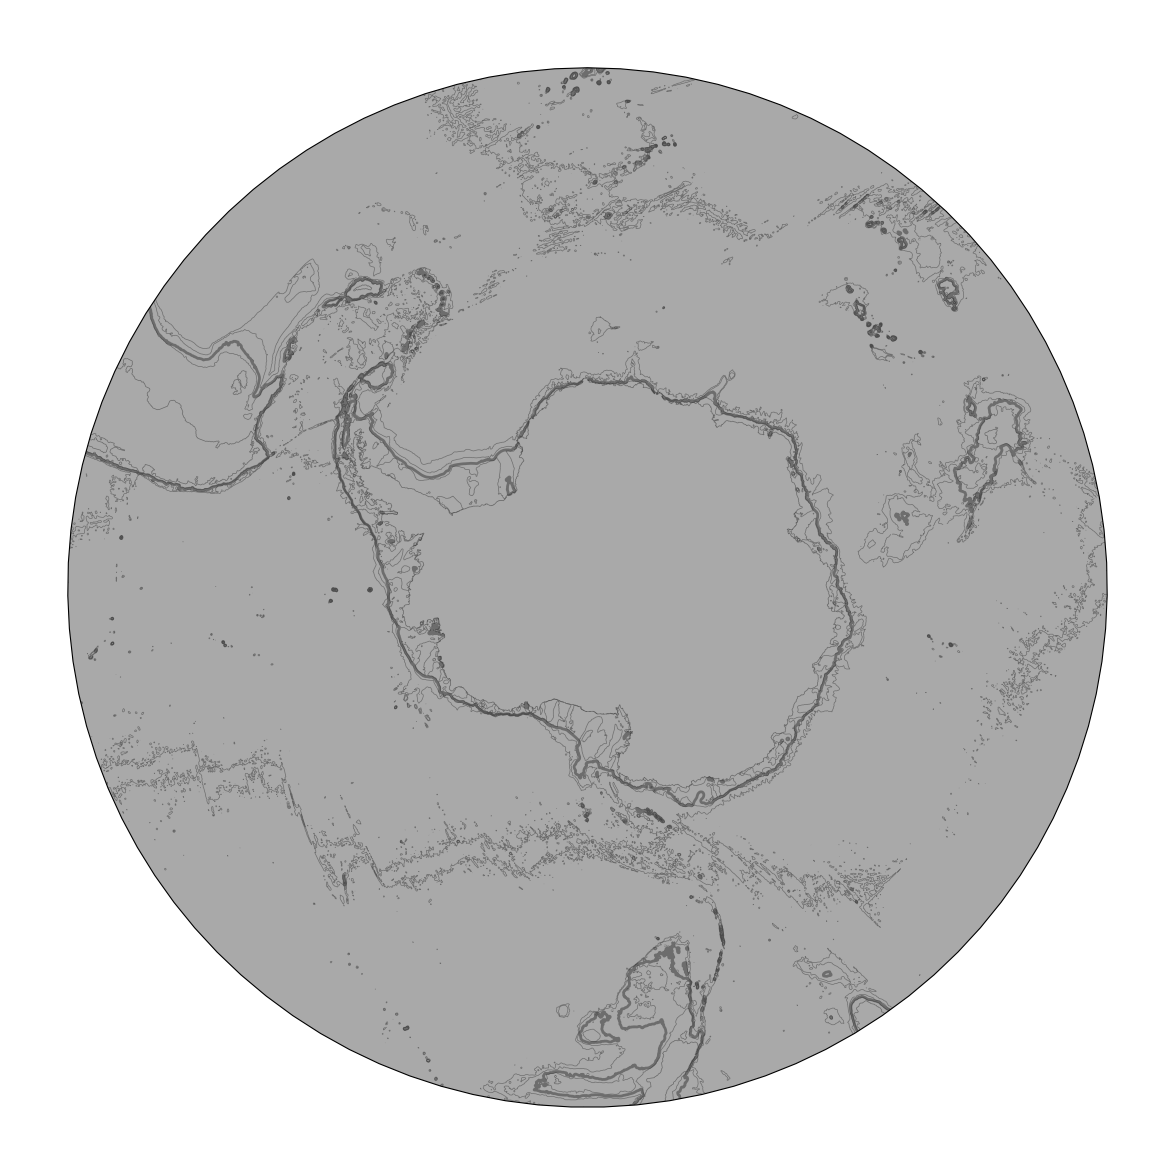

In [135]:
fig = plt.figure(1, figsize=(15, 15))

ax = plt.subplot(1, 1, 1, projection=ccrs.SouthPolarStereo(), facecolor="darkgrey")
ax.set_boundary(circle, transform=ax.transAxes)
    
# Filled land 
#land.plot.contourf(ax=ax, colors='darkgrey', zorder=2, transform=ccrs.PlateCarree(), add_colorbar=False)

# Coastline
#land.fillna(0).plot.contour(ax=ax, colors='k', levels=[0, 1], transform=ccrs.PlateCarree(), add_colorbar=False)

ax.contour(land_mask.cf['X'], land_mask.cf['Y'], land_mask,
           levels = [0, 1], colors = 'dimgrey',linewidths=0.5, transform = ccrs.PlateCarree())
#ax.contour(shelf_mask.cf['X'], shelf_mask.cf['Y'], shelf_mask,
           #levels = [0, 1], colors = 'r', linewidths=0.5,transform = ccrs.PlateCarree())

# Depth contours
data_fixed.deptho.plot.contour(ax=ax, levels=[500, 1000, 2000, 3000],
                colors='0.2', linewidths=[0.5, 2, 0.5, 0.5], alpha=0.5,
                transform=ccrs.PlateCarree())

# Along slope barotropic velocity
sc = barotropic_alongslope_velocity.plot(ax=ax, cmap=cm.cm.curl,
                                         transform=ccrs.PlateCarree(),
                                         vmin=-0.3, vmax=0.3,
                                         cbar_kwargs={'orientation': 'vertical',
                                                      'shrink': 0.25,
                                                      'extend': 'both',
                                                      'label': None,
                                                      'aspect': 8})
  
ax.set_title('Along-slope barotropic velocity (m s$^{-1}$)');

In [ ]:
client.close()